In [53]:
import torch.nn as nn
import torch
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import torch.nn.functional as F
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [54]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(12,40)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(40,30)
        self.linear3 = nn.Linear(30,20)
        self.linear4 = nn.Linear(20,10)
        self.linear5 = nn.Linear(10,5)
        self.linear6 = nn.Linear(5,4)
        self.output_layer = nn.Linear(4,4)
        self.softmax = nn.Softmax()
        self.layer_list = [self.linear1, self.linear2, self.linear3, self.linear4, self.linear5, self.linear6]

    # x represents our data
    def forward(self, x):
        for layer in self.layer_list:
            x = layer(x)
            x = self.activation(x)
        x = self.output_layer(x)
        output = self.softmax(x)
        return output

In [55]:
intervalo = "12h"
model = Net()
model.load_state_dict(torch.load(rf'saved_models\model_{intervalo}_350'))

<All keys matched successfully>

In [56]:
df = pd.read_csv(rf'data\ann_data\2021_2024\full_data_with_true_labels_{intervalo}.csv')
timestamp_inicio_backtest = 1690027200000

In [57]:
idx_val = df[df['timestamp_ms']==timestamp_inicio_backtest].index[0]
df_backtest = df[idx_val:].reset_index(drop=True)
atributos_input = ['EMA2', 'EMA4', 'EMA12', 'EMA24', 'EMSD2', 'EMSD4', 'EMSD12', 'EMSD24', 'RSI12', 'RSI24', 'RSI48', 'prev_return']


In [58]:
model.eval()
preds = []

for idx,row in df_backtest.iterrows():
    model_inputs = row[atributos_input]
    np_array = model_inputs.to_numpy(dtype=np.float32)
    torch_tensor = torch.tensor(np_array)
    output = model(torch_tensor)
    pred = max(range(len(output)), key=output.__getitem__)
    preds.append(pred)

df_backtest['prediction'] = preds

c:\Users\luisg\anaconda3\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
c:\Users\luisg\anaconda3\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
c:\Users\luisg\anaconda3\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
c:\Users\luisg\anaconda3\lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
c:\Users\luisg\anaconda3\lib\site-packages\t

In [59]:
df_backtest['log_returns'] = np.log(1+df_backtest['returns'])

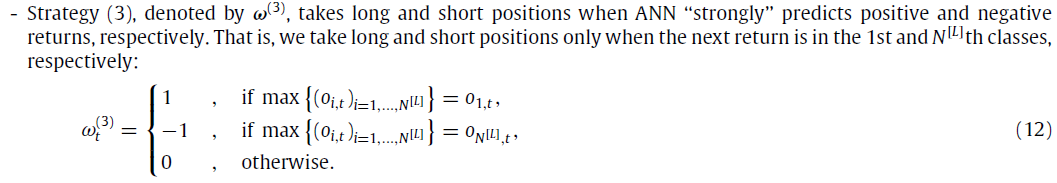

In [60]:
w = pd.Series(np.where(df_backtest['prediction']==0, 1, 0))
w = pd.Series(np.where(df_backtest['prediction']==3, -1, w))
df_backtest['w'] = w
df_backtest['w'].value_counts()

 0    588
 1     60
-1     26
Name: w, dtype: int64

In [61]:
trades_bool_idx = []
in_position=False
for idx,row in df_backtest.iterrows():
    if row['w'] == 1:
        in_position = True
    if row['w'] == -1:
        in_position = False
    trades_bool_idx.append(in_position)
df_backtest['in_position'] = trades_bool_idx
    

In [62]:
df_backtest

,timestamp_ms,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,PR48,NR48,RSI12,RSI24,RSI48,label,prediction,log_returns,w,in_position
0,1690027200000,29886.93,29908.71,29625.10,29794.00,7144.33751,1690070399999,2.129126e+08,221048,3222.40172,...,7.293772,8.977216,0.362093,0.456306,0.448269,2,2,-0.003115,0,False
1,1690070400000,29793.99,29980.88,29730.00,29888.58,7141.58416,1690113599999,2.134405e+08,207392,3444.75032,...,7.293772,8.441114,0.354566,0.446318,0.463541,1,2,0.003169,0,False
2,1690113600000,29888.59,30350.00,29852.29,30083.75,11151.20221,1690156799999,3.354998e+08,312042,5444.60663,...,7.293772,8.235160,0.350607,0.418405,0.469689,1,2,0.006509,0,False
3,1690156800000,30083.75,30099.58,29000.00,29269.99,21428.83226,1690199999999,6.328427e+08,459011,9591.51196,...,6.550426,8.235160,0.397063,0.430015,0.443028,3,2,-0.027422,0,False
4,1690200000000,29269.99,29270.00,28861.90,29176.50,18200.16465,1690243199999,5.297197e+08,410096,8456.15590,...,6.830306,7.894595,0.461324,0.427799,0.463861,2,2,-0.003199,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,1718928000000,64869.99,65066.66,63522.75,63770.00,12284.45149,1718971199999,7.899534e+08,608967,5355.16596,...,7.380100,9.387463,0.414271,0.358324,0.440141,3,2,-0.017102,0,True
670,1718971200000,63770.01,64460.14,63379.35,64143.56,13709.11293,1719014399999,8.755881e+08,753650,7188.09364,...,6.735959,10.282567,0.393760,0.325354,0.395802,1,2,0.005841,0,True
671,1719014400000,64143.56,64546.81,63943.82,64265.26,5113.08838,1719057599999,3.288513e+08,344251,2613.03668,...,6.735959,10.367170,0.311536,0.298401,0.393844,1,2,0.001896,0,True
672,1719057600000,64265.27,64397.82,64218.50,64262.01,2195.86704,1719100799999,1.411759e+08,218581,1143.25377,...,6.985673,10.359509,0.349339,0.304102,0.402744,1,2,-0.000051,0,True


In [63]:
first_trade = pd.Series(df_backtest.index == (df_backtest['w'] == 1).idxmax(),index=df_backtest.index)
first_trade

0      False
1      False
2      False
3      False
4      False
       ...  
669    False
670    False
671    False
672    False
673    False
Length: 674, dtype: bool

In [64]:
# first_buy = pd.Series(df.index == (df['close'] > df[strat_name]).idxmax(),index=df.index)

trades_df = df_backtest[first_trade | df_backtest['in_position'].diff()]
if trades_df.shape[0] % 2 != 0:
    mtm = df_backtest.iloc[-1:,]
    trades_df = pd.concat([trades_df,mtm], axis='index')

In [65]:
trades_df

,timestamp_ms,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,PR48,NR48,RSI12,RSI24,RSI48,label,prediction,log_returns,w,in_position
53,1692316800000,26623.41,26832.60,26157.71,26494.00,33530.349640,1692359999999,8.884845e+08,689838,16415.405760,...,3.791901,5.505964,0.089273,0.357217,0.407825,2,0,-0.004873,1,True
195,1698451200000,33892.01,34493.33,33860.00,34175.84,9519.171610,1698494399999,3.248730e+08,325909,4730.631990,...,14.599521,5.456820,0.832967,0.857321,0.727925,1,3,0.008339,-1,False
197,1698537600000,34081.01,34321.89,33930.00,34253.81,6290.109820,1698580799999,2.145900e+08,268936,2947.923600,...,14.736529,5.443674,0.818833,0.832717,0.730247,1,0,0.005058,1,True
198,1698580800000,34253.81,34750.11,34253.80,34525.89,14395.411940,1698623999999,4.970629e+08,448544,7106.037360,...,14.414164,5.581503,0.804808,0.808224,0.720864,1,3,0.007912,-1,False
200,1698667200000,34608.51,34856.00,34062.84,34474.73,19416.647820,1698710399999,6.701191e+08,634890,8557.048390,...,14.971851,4.959035,0.665792,0.827979,0.751188,2,0,-0.003873,1,True
444,1709208000000,62936.02,63531.88,60364.70,61130.98,41491.088190,1709251199999,2.568282e+09,1643808,20390.774020,...,22.677522,5.710443,0.903028,0.761087,0.798843,3,3,-0.029100,-1,False
446,1709294400000,61863.71,63114.23,61131.01,62387.90,27220.673370,1709337599999,1.692681e+09,1116637,13931.326310,...,22.395531,6.493491,0.846749,0.726761,0.775226,1,0,0.008437,1,True
447,1709337600000,62387.90,62433.19,61641.10,61826.32,14699.840250,1709380799999,9.120234e+08,870135,7039.028000,...,22.809308,6.493491,0.849293,0.732766,0.778400,2,3,-0.009042,-1,False
458,1709812800000,66905.34,67980.00,66541.10,66823.17,30069.115290,1709855999999,2.023487e+09,1310386,15528.664800,...,24.563575,10.549775,0.643267,0.744160,0.699551,2,0,-0.001229,1,True
460,1709899200000,67741.22,69990.00,66082.66,68124.19,56689.416802,1709942399999,3.864072e+09,2139080,28996.078041,...,23.240777,10.235966,0.629623,0.740538,0.694237,1,3,0.005638,-1,False


In [66]:
def get_strategy_log_returns(df, trades_idx, strategy_name):
    trades = df.loc[trades_idx,'close']
    if len(trades) % 2 != 0:
        mtm = df.close[-1:]
        trades = pd.concat([trades,mtm])
    returns = []
    positions = []
    trades_idx_list = list(trades_idx)
    in_position = False
    for idx,row in df.iterrows():
        positions.append(in_position)
        if in_position:
            r = row['returns']
        else:
            r = 0
        if idx in trades_idx_list:
            trades_list_index = trades_idx_list.index(idx)
            if trades_list_index % 2 == 0: #compra
                in_position = True
            else: #venda
                in_position = False
        returns.append(r)
    df[f'{strategy_name}_in_position'] = positions
    df[f'{strategy_name}_log_returns'] = np.where(df[f'{strategy_name}_in_position'], df['log_returns'], 0)
    print(f"coluna {strategy_name}_log_returns criada")
    # return df

In [67]:
df_backtest

,timestamp_ms,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,PR48,NR48,RSI12,RSI24,RSI48,label,prediction,log_returns,w,in_position
0,1690027200000,29886.93,29908.71,29625.10,29794.00,7144.33751,1690070399999,2.129126e+08,221048,3222.40172,...,7.293772,8.977216,0.362093,0.456306,0.448269,2,2,-0.003115,0,False
1,1690070400000,29793.99,29980.88,29730.00,29888.58,7141.58416,1690113599999,2.134405e+08,207392,3444.75032,...,7.293772,8.441114,0.354566,0.446318,0.463541,1,2,0.003169,0,False
2,1690113600000,29888.59,30350.00,29852.29,30083.75,11151.20221,1690156799999,3.354998e+08,312042,5444.60663,...,7.293772,8.235160,0.350607,0.418405,0.469689,1,2,0.006509,0,False
3,1690156800000,30083.75,30099.58,29000.00,29269.99,21428.83226,1690199999999,6.328427e+08,459011,9591.51196,...,6.550426,8.235160,0.397063,0.430015,0.443028,3,2,-0.027422,0,False
4,1690200000000,29269.99,29270.00,28861.90,29176.50,18200.16465,1690243199999,5.297197e+08,410096,8456.15590,...,6.830306,7.894595,0.461324,0.427799,0.463861,2,2,-0.003199,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,1718928000000,64869.99,65066.66,63522.75,63770.00,12284.45149,1718971199999,7.899534e+08,608967,5355.16596,...,7.380100,9.387463,0.414271,0.358324,0.440141,3,2,-0.017102,0,True
670,1718971200000,63770.01,64460.14,63379.35,64143.56,13709.11293,1719014399999,8.755881e+08,753650,7188.09364,...,6.735959,10.282567,0.393760,0.325354,0.395802,1,2,0.005841,0,True
671,1719014400000,64143.56,64546.81,63943.82,64265.26,5113.08838,1719057599999,3.288513e+08,344251,2613.03668,...,6.735959,10.367170,0.311536,0.298401,0.393844,1,2,0.001896,0,True
672,1719057600000,64265.27,64397.82,64218.50,64262.01,2195.86704,1719100799999,1.411759e+08,218581,1143.25377,...,6.985673,10.359509,0.349339,0.304102,0.402744,1,2,-0.000051,0,True


In [68]:
get_strategy_log_returns(df_backtest, trades_df.index, f'neural_net_{intervalo}')
df_backtest.dropna(inplace=True)
df_backtest.reset_index(drop=True, inplace=True)

coluna neural_net_12h_log_returns criada


In [69]:
df_backtest[f'neural_net_{intervalo}_log_returns']

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
669   -0.017102
670    0.005841
671    0.001896
672   -0.000051
673    0.001235
Name: neural_net_12h_log_returns, Length: 674, dtype: float64

In [70]:
df_backtest['retorno_acumulado_bh'] = np.exp(df_backtest['log_returns']).cumprod()
df_backtest[f'retorno_acumulado_nnet_{intervalo}'] = np.exp(df_backtest[f'neural_net_{intervalo}_log_returns']).cumprod()

In [71]:
df_backtest.to_csv(rf'data/resultados/nnet_{intervalo}.csv', index=False)

In [72]:
import datetime as dt

In [73]:
df_backtest['date'] = pd.to_datetime(df_backtest['timestamp_ms'], unit='ms')

In [74]:
df_backtest

,timestamp_ms,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,label,prediction,log_returns,w,in_position,neural_net_12h_in_position,neural_net_12h_log_returns,retorno_acumulado_bh,retorno_acumulado_nnet_12h,date
0,1690027200000,29886.93,29908.71,29625.10,29794.00,7144.33751,1690070399999,2.129126e+08,221048,3222.40172,...,2,2,-0.003115,0,False,False,0.000000,0.996890,1.000000,2023-07-22 12:00:00
1,1690070400000,29793.99,29980.88,29730.00,29888.58,7141.58416,1690113599999,2.134405e+08,207392,3444.75032,...,1,2,0.003169,0,False,False,0.000000,1.000055,1.000000,2023-07-23 00:00:00
2,1690113600000,29888.59,30350.00,29852.29,30083.75,11151.20221,1690156799999,3.354998e+08,312042,5444.60663,...,1,2,0.006509,0,False,False,0.000000,1.006585,1.000000,2023-07-23 12:00:00
3,1690156800000,30083.75,30099.58,29000.00,29269.99,21428.83226,1690199999999,6.328427e+08,459011,9591.51196,...,3,2,-0.027422,0,False,False,0.000000,0.979357,1.000000,2023-07-24 00:00:00
4,1690200000000,29269.99,29270.00,28861.90,29176.50,18200.16465,1690243199999,5.297197e+08,410096,8456.15590,...,2,2,-0.003199,0,False,False,0.000000,0.976229,1.000000,2023-07-24 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,1718928000000,64869.99,65066.66,63522.75,63770.00,12284.45149,1718971199999,7.899534e+08,608967,5355.16596,...,3,2,-0.017102,0,True,True,-0.017102,2.133708,2.252934,2024-06-21 00:00:00
670,1718971200000,63770.01,64460.14,63379.35,64143.56,13709.11293,1719014399999,8.755881e+08,753650,7188.09364,...,1,2,0.005841,0,True,True,0.005841,2.146207,2.266132,2024-06-21 12:00:00
671,1719014400000,64143.56,64546.81,63943.82,64265.26,5113.08838,1719057599999,3.288513e+08,344251,2613.03668,...,1,2,0.001896,0,True,True,0.001896,2.150279,2.270431,2024-06-22 00:00:00
672,1719057600000,64265.27,64397.82,64218.50,64262.01,2195.86704,1719100799999,1.411759e+08,218581,1143.25377,...,1,2,-0.000051,0,True,True,-0.000051,2.150170,2.270316,2024-06-22 12:00:00


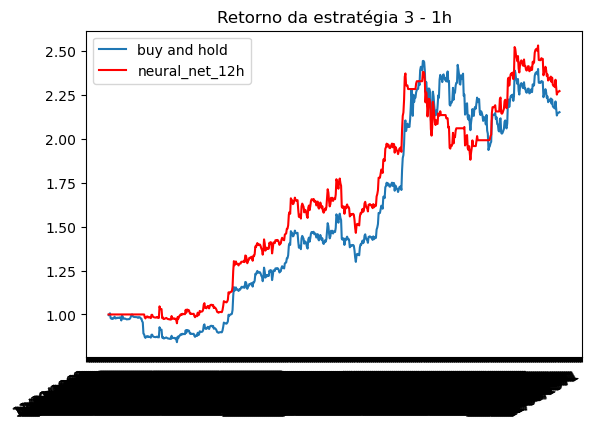

In [77]:

start = 0
end = 8239
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()
plt.plot(np.exp(df_backtest['log_returns'][start:end]).cumprod(), label='buy and hold')
plt.plot(np.exp(df_backtest['neural_net_12h_log_returns'][start:end]).cumprod(), c='red', label='neural_net_12h')
# plt.xticks(df_backtest['date'])
# plt.xlabel('qtd de cpu')
# plt.ylabel('fator speedup')
plt.title('Retorno da estratégia 3 - 1h')
# plt.grid(True)
# x_intervals = np.array([ 0, 10, 20, 30, 40, 48]) 
# y_intervals = np.arange(0, 9, 1) 
# plt.xticks(x_intervals)
# plt.yticks(y_intervals)
plt.legend()
plt.show()

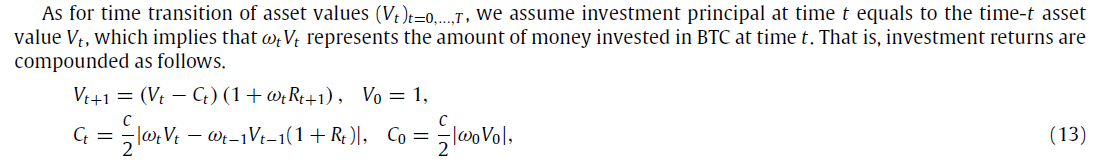

In [ ]:
#primeiro teste com c=0
df_backtest['prev_w'] = df_backtest['w'].shift()

In [ ]:
df_backtest

In [ ]:
V = [1]
for idx,row in df_backtest.iterrows():
    if idx>0:
        V.append(V[-1]*(1+row['prev_w']*row['returns']))


In [ ]:
V[-1]

In [ ]:
df_backtest['close']